<font size="1">
Supplementary code for "Build a Large Language Model From Scratch": <a href="https://www.manning.com/books/build-a-large-language-model-from-scratch">https://www.manning.com/books/build-a-large-language-model-from-scratch</a> by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>

# Finetuning for Unisup Naming Notifcn Text Classification

In [178]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.2
numpy version: 1.26.2
tiktoken version: 0.6.0
torch version: 2.2.1+cu121
tensorflow version: 2.16.1
pandas version: 2.1.4


## E.2 Preparing the dataset

- This section repeats the code from chapter 6 to load and prepare the dataset
- Instead of repeating this code, one could copy & paste the LoRA code from section E.3 at the end of the chapter 6 notebook
- (The LoRA code was originally the last section of chapter 6 but was moved to the appendix due to the length of chapter 6)
- In similar fashion, we could also apply LoRA to the models in chapter 7 for instruction finetuning

In [179]:
from pathlib import Path
import pandas as pd
from previous_scope import (
    download_and_unzip,
    create_balanced_dataset,
    random_split
)


#url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
#zip_path = "sms_spam_collection.zip"
#extracted_path = "sms_spam_collection"
#data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
data_file_path = "/teamspace/studios/this_studio/spam_notificn_classifier.tsv"
#download_and_unzip(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)


In [180]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,No,X/PVV/COAT4/TA871
1,No,A/PVV/PASS/FZ18/IF911A
2,No,X/PVV/COAT4/IF911B
3,No,"10""NG-4-3009-C511 FUITE"
4,No,X/PVV/ANOD/TA023
...,...,...
80526,No,Major Intrus.insp_TO-FA-31100-5FL.ARRAST
80527,No,DAL/BUOY COMPART_INTRUSIVE
80528,No,DAL/BUOY COMPART_INTRUSIVE
80529,No,DAL/BUOY COMPART_INTRUSIVE


- When we check the class distribution, we see that the data contains "ham" (i.e., not-SPAM) much more frequently than "spam"

In [181]:
print(df["Label"].value_counts())

Label
No     57855
Yes    22676
Name: count, dtype: int64


- For simplicity, and because we prefer a small dataset for educational purposes anyway (it will make it possible to finetune the LLM faster), we subsample (undersample) the dataset so that it contains 747 instances from each class
- (Next to undersampling, there are several other ways to deal with class balances, but they are out of the scope of a book on LLMs; you can find examples and more information in the [`imbalanced-learn` user guide](https://imbalanced-learn.org/stable/user_guide.html))

In [182]:

def create_balanced_dataset(df):

    # Count the instances of "spam"
    num_spam = df[df["Label"] == "Yes"].shape[0]

    # Randomly sample "ham' instances to match the number of 'spam' instances
    ham_subset = df[df["Label"] == "No"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "Yes"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
No     22676
Yes    22676
Name: count, dtype: int64


In [183]:
balanced_df["Label"] = balanced_df["Label"].map({"No": 0, "Yes": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train_naming.csv", index=None)
validation_df.to_csv("validation_naming.csv", index=None)
test_df.to_csv("test_naming.csv", index=None)

In [184]:
print(df["Label"].value_counts())

Label
No     57855
Yes    22676
Name: count, dtype: int64


In [185]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [186]:
token_ids = tokenizer.encode("This is the first text message")
print(token_ids)

[1212, 318, 262, 717, 2420, 3275]


In [187]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [188]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- We also pad the validation and test set to the longest training sequence
- Note that validation and test set samples that are longer than the longest training example are being truncated via `encoded_text[:self.max_length]` in the `SpamDataset` code
- This behavior is entirely optional, and it would also work well if we set `max_length=None` in both the validation and test set cases

In [189]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

- Next, we use the dataset to instantiate the data loaders, which is similar to creating the data loaders in previous chapters

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/batch.webp" width=500px>

In [190]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- As a verification step, we iterate through the data loaders and check that the batches contain 8 training examples each, where each training example consists of 120 tokens

In [191]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- Lastly, let's print the total number of batches in each dataset

In [192]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 Initializing a model with pretrained weights

- In this section, we initialize the pretrained model we worked with in the previous chapter

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-2.webp" width=500px>

- This section repeats the code from chapter 6 to load and prepare the model

In [193]:
from gpt_download import download_and_load_gpt2
from previous_scope import GPTModel, load_weights_into_gpt


CHOOSE_MODEL = "gpt2-xl (1558M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 184kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.38MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 222kiB/s]
model.ckpt.data-00000-of-00001:   4%|▍         | 275M/6.23G [00:09<03:06, 32.0MiB/s]  

model.ckpt.data-00000-of-00001: 100%|██████████| 6.23G/6.23G [03:21<00:00, 30.9MiB/s]
model.ckpt.index: 100%|██████████| 20.7k/20.7k [00:00<00:00, 582kiB/s]
model.ckpt.meta: 100%|██████████| 1.84M/1.84M [00:00<00:00, 5.30MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.20MiB/s]


- To ensure that the model was loaded corrected, let's double-check that it generates coherent text

In [194]:
from previous_scope import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you closer to the goal.

The goal is to be the best you


In [195]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'X/PVV/COAT4/TA871'"
    " Answer with 'yes' or 'no'."
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'X/PVV/COAT4/TA871' Answer with 'yes' or 'no'.

The following text 'spam'? Answer with 'yes' or 'no': 'X/PV


- In this section, we are modifying the pretrained LLM to make it ready for classification finetuning
- Let's take a look at the model architecture first

In [196]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 1600)
  (pos_emb): Embedding(1024, 1600)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1600, out_features=1600, bias=True)
        (W_key): Linear(in_features=1600, out_features=1600, bias=True)
        (W_value): Linear(in_features=1600, out_features=1600, bias=True)
        (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1600, out_features=6400, bias=True)
          (1): GELU()
          (2): Linear(in_features=6400, out_features=1600, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

- Above, we can see the architecture we implemented in chapter 4 neatly laid out
- The goal is to replace and finetune the output layer
- To achieve this, we first freeze the model, meaning that we make all layers non-trainable

In [197]:
for param in model.parameters():
    param.requires_grad = False

- Then, we replace the output layer (`model.out_head`), which originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary)
- Since we finetune the model for binary classification (predicting 2 classes, "spam" and "ham"), we can replace the output layer as shown below, which will be trainable by default
- Note that we use `BASE_CONFIG["emb_dim"]` (which is equal to 768 in the `"gpt2-small (124M)"` model) to keep the code below more general

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/trainable.webp" width=500px>

In [198]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- Technically, it's sufficient to only train the output layer
- However, as I found in [experiments finetuning additional layers](https://magazine.sebastianraschka.com/p/finetuning-large-language-models) can noticeably improve the performance
- So, we are also making the last transformer block and the final `LayerNorm` module connecting the last transformer block to the output layer trainable

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/trainable.webp" width=500px>

In [199]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

- We can still use this model similar to before in previous chapters
- For example, let's feed it some text input

In [200]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


- What's different compared to previous chapters is that it now has two output dimensions instead of 50,257

In [201]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[ 0.1746,  0.6253],
         [-0.7584,  0.0307],
         [ 0.1333,  0.7560],
         [-0.0609,  0.4414]]])
Outputs dimensions: torch.Size([1, 4, 2])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/input-and-output.webp" width=500px>

- As discussed in previous chapters, for each input token, there's one output vector
- Since we fed the model a text sample with 6 input tokens, the output consists of 6 2-dimensional output vectors above
- In chapter 3, we discussed the attention mechanism, which connects each input token to each other input token
- In chapter 3, we then also introduced the causal attention mask that is used in GPT-like models; this causal mask lets a current token only attend to the current and previous token positions
- Based on this causal attention mechanism, the 6th (last) token above contains the most information among all tokens because it's the only token that includes information about all other tokens
- Hence, we are particularly interested in this last token, which we will finetune for the spam classification task

In [202]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-0.0609,  0.4414]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/attention-mask.webp" width=200px>

## 6.6 Calculating the classification loss and accuracy

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-3.webp" width=500px>

- Before we can start finetuning (/training), we first have to define the loss function we want to optimize during training
- The goal is to maximize the spam classification accuracy of the model; however, classification accuracy is not a differentiable function
- Hence, instead, we minimize the cross entropy loss as a proxy for maximizing the classification accuracy (you can learn more about this topic in lecture 8 of my freely available [Introduction to Deep Learning](https://sebastianraschka.com/blog/2021/dl-course.html#l08-multinomial-logistic-regression--softmax-regression) class.

- Note that in chapter 5, we calculated the cross entropy loss for the next predicted token over the 50,257 token IDs in the vocabulary
- Here, we calculate the cross entropy in a similar fashion; the only difference is that instead of 50,257 token IDs, we now have only two choices: spam (label 1) or ham (label 0).
- In other words, the loss calculation training code is practically identical to the one in chapter 5, but we now only have two labels instead of 50,257 labels (token IDs).


- Consequently, the `calc_loss_batch` function is the same here as in chapter 5, except that we are only interested in optimizing the last token `model(input_batch)[:, -1, :]` instead of all tokens `model(input_batch)`:

In [203]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

The `calc_loss_loader` is exactly the same as in chapter 5:

In [204]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- Using the `calc_closs_loader`, we compute the initial training, validation, and test set losses before we start training
- Here, we use `torch.no_grad()` so that no gradients are computed during the forward pass, which reduces memory consumption and speeds up computations since we are not training the model yet
- Via the `device` setting, the  model automatically runs on a GPU if a GPU with Nvidia CUDA support is available and otherwise runs on a CPU

In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.709
Validation loss: 0.690
Test loss: 0.680


- Similar to the `calc_loss_loader` function above, we can define a `calc_accuracy_loader` function that calculates the classification accuracy by checking how many predicted class (spam and ham) labels match the given labels in the dataset
- Note that the classification accuracy is a mathematically non-differentiable function, and we only use it for evaluation; hence, we can disable the gradient calculation permanently to save resources here
- We can disable the gradient tracking either using the `with torch.no_grad():` inside the function or by using the `@torch.no_grad()` function decorator

In [206]:
@torch.no_grad() # Disable gradient tracking for efficiency
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

- Let's check the initial classification accuracy before we start training the model:

In [207]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- As we can see, the model only gets roughly half (50%) of the predictions correctly
- In the next section, we train the model to improve the classification accuracy

## 6.7 Finetuning the model on supervised data

- In this section, we define and use the training function to improve the classification accuracy of the model
- The `train_classifier_simple` function below is practically the same as the `train_model_simple` function we used for pretraining the model in chapter 5
- The only two differences are that we now 
  1. track the number of training examples seen (`examples_seen`) instead of the number of tokens seen
  2. calculate the accuracy after each epoch instead of printing a sample text after each epoch

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/training-loop.webp" width=500px>

In [208]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous epoch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

- The `evaluate_model` function used in the `train_classifier_simple` is the same as the one we used in chapter 5

In [209]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

- The training takes about 5 minutes on a M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU

In [210]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.686, Val loss 0.685
Ep 1 (Step 000050): Train loss 0.359, Val loss 0.378
Ep 1 (Step 000100): Train loss 0.059, Val loss 0.082
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 2 (Step 000150): Train loss 0.058, Val loss 0.131
Ep 2 (Step 000200): Train loss 0.008, Val loss 0.053
Ep 2 (Step 000250): Train loss 0.035, Val loss 0.053
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.043, Val loss 0.179
Ep 3 (Step 000350): Train loss 0.009, Val loss 0.063
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.012, Val loss 0.096
Ep 4 (Step 000450): Train loss 0.028, Val loss 0.076
Ep 4 (Step 000500): Train loss 0.030, Val loss 0.039
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.108, Val loss 0.042
Ep 5 (Step 000600): Train loss 0.003, Val loss 0.056
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 3.84 m

- Similar to chapter 5, we use matplotlib to plot the loss function for the training and validation set

In [211]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

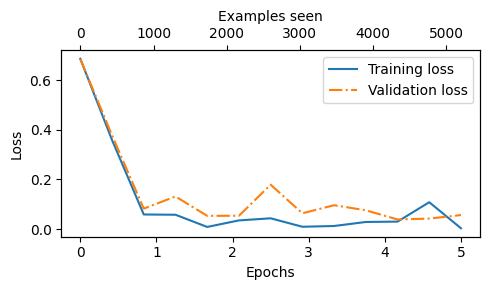

In [212]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- Above, based on the downward slope, we see that the model learns well
- Furthermore, the fact that the training and validation loss are very close indicates that the model does not tend to overfit the training data
- Similarly, we can plot the accuracy below

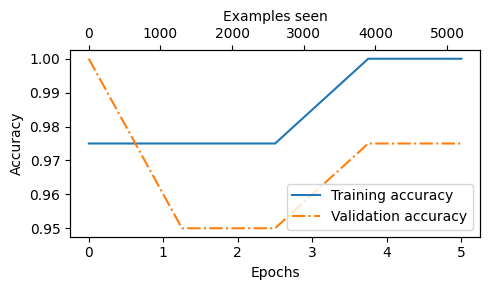

In [213]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- Based on the accuracy plot above, we can see that the model achieves a relatively high training and validation accuracy after epochs 4 and 5
- However, we have to keep in mind that we specified `eval_iter=5` in the training function earlier, which means that we only estimated the training and validation set performances
- We can compute the training, validation, and test set performances over the complete dataset as follows below

In [214]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.81%
Validation accuracy: 97.32%
Test accuracy: 97.67%


- We can see that the training and test set performances are practically identical
- However, based on the slightly lower test set performance, we can see that the model overfits the training data to a very small degree
- This is normal, however, and this gap could potentially be further reduced by increasing the model's dropout rate (`drop_rate`) or the `weight_decay` in the optimizer setting

## 6.8 Using the LLM as a SPAM classifier

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-4.webp" width=500px>

- Finally, let's use the finetuned GPT model in action
- The `classify_review` function below implements the data preprocessing steps similar to the `SpamDataset` we implemented earlier
- Then, the function returns the predicted integer class label from the model and returns the corresponding class name

In [215]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "Proper Naming Notfcn" if predicted_label == 1 else "Wrong Naming Notificn"

- Let's try it out on a few examples below

In [225]:
text_1 = (
    "A/LIFT/MECA/HU-JH-7891"
    
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

Wrong Naming Notificn


In [226]:
text_2 = (
    "S/PIP/TBR1/PU3"
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

Wrong Naming Notificn


- Finally, let's save the model in case we want to reuse the model later without having to train it again

In [218]:
torch.save(model.state_dict(), "review_classifier.pth")

- Then, in a new session, we could load the model as follows

In [219]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>